# Model recovery attack: `wine`

In [1]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import mra
from mra import *

# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
def make_dataset(X, Y, f):
    x = tf.data.Dataset.from_tensor_slices(X)
    y = tf.data.Dataset.from_tensor_slices(Y)
    x = x.map(f)
    xy = tf.data.Dataset.zip((x, y))
    xy = xy.shuffle(10000)
    return xy

xy = np.loadtxt("../datasets/wine-white.csv", delimiter=";")
np.random.shuffle(xy)
x = xy[:,0:-1]
y = xy[:,-1]-3

min_values = np.array([min(x[:,i]) for i in range(x.shape[1])])
max_values = np.array([max(x[:,i]) for i in range(x.shape[1])])
x = (x-min_values)/(max_values - min_values)
y = y.reshape((len(x), 1)).astype("float32")
train_ds = make_dataset(x, y, lambda t: t)

2022-02-17 15:25:02.909705: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-17 15:25:13.287140: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 26777 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:01:00.0, compute capability: 8.0


In [3]:
mra_wine_2 = mra(train_ds)

In [4]:
def make_f(input_shape):
    xin = tf.keras.layers.Input(input_shape)
    x = tf.keras.layers.Dense(64, activation="relu")(xin)
    output = tf.keras.layers.Dense(64, activation="relu")(x)
    return tf.keras.Model(xin, output)

def make_g(input_shape):
    xin = tf.keras.layers.Input(input_shape)
    x = tf.keras.layers.Dense(64, activation="relu")(xin)
    x = tf.keras.layers.Dense(64, activation="relu")(x)
    # x = tf.keras.layers.Dropout(0.5)(x)
    output = tf.keras.layers.Dense(7, activation="softmax")(x)
    return tf.keras.Model(xin, output)

In [6]:
log_train = mra_wine_2.train(
    make_f,
    make_g,
    loss_fn=tf.keras.losses.sparse_categorical_crossentropy,
    batch_size=32,
    epoch=5,
    lr=0.001,
    verbose=True, log_every=50
    )

2022-02-17 15:25:53.630728: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Iteration 0001: Training loss: 1.9354
Iteration 0051: Training loss: 1.2498
Iteration 0101: Training loss: 1.2552
Iteration 0151: Training loss: 1.2496
Iteration 0201: Training loss: 1.1069
Iteration 0251: Training loss: 1.0270
Iteration 0301: Training loss: 1.0604
Iteration 0351: Training loss: 1.3651
Iteration 0401: Training loss: 1.2156
Iteration 0451: Training loss: 1.3016
Iteration 0501: Training loss: 1.3643
Iteration 0551: Training loss: 1.2016
Iteration 0601: Training loss: 0.9885
Iteration 0651: Training loss: 1.2025
Iteration 0701: Training loss: 1.0678
Iteration 0751: Training loss: 1.3713


In [7]:
def make_generator(input_shape):
    xin = tf.keras.layers.Input(input_shape)
    act = "relu"
    x = tf.keras.layers.Dense(512, activation=act)(xin)
    x = tf.keras.layers.Dense(256, activation=act)(x)
    x = tf.keras.layers.Dense(128, activation=act)(x)
    x = tf.keras.layers.Dense(64, activation=act)(x)
    x = tf.keras.layers.Dense(32, activation=act)(x)
    x = tf.keras.layers.Dense(11, activation="sigmoid")(x)
    return tf.keras.Model(xin, x)

In [8]:
log_attack = mra_wine_2.attack(
    attack_iter=100,
    make_generator=make_generator,
    input_noise="normal",
    input_z=True,
    model_leak=True,
    lr_x=0.001,
    lr_f=0.0001,
    epoch=200,
    iter_x=50,
    iter_f=1,
    verbose=True, log_every=1)

Iteration 0001: RG-uniform: 0.1884, RG-normal: 0.1682, reconstruction validation: 0.0003
Iteration 0002: RG-uniform: 0.1632, RG-normal: 0.1538, reconstruction validation: 0.0001
Iteration 0003: RG-uniform: 0.1600, RG-normal: 0.1612, reconstruction validation: 0.0003
Iteration 0004: RG-uniform: 0.1710, RG-normal: 0.1588, reconstruction validation: 0.0006
Iteration 0005: RG-uniform: 0.1807, RG-normal: 0.1669, reconstruction validation: 0.0008
Iteration 0006: RG-uniform: 0.1682, RG-normal: 0.1641, reconstruction validation: 0.0012
Iteration 0007: RG-uniform: 0.1974, RG-normal: 0.1614, reconstruction validation: 0.0015
Iteration 0008: RG-uniform: 0.1816, RG-normal: 0.1698, reconstruction validation: 0.0013
Iteration 0009: RG-uniform: 0.1722, RG-normal: 0.1614, reconstruction validation: 0.0025
Iteration 0010: RG-uniform: 0.1880, RG-normal: 0.1600, reconstruction validation: 0.0045
Iteration 0011: RG-uniform: 0.1592, RG-normal: 0.1619, reconstruction validation: 0.0030
Iteration 0012: RG-un

In [9]:
np.savetxt("./log/wine-white-2.csv", log_attack, delimiter=",")

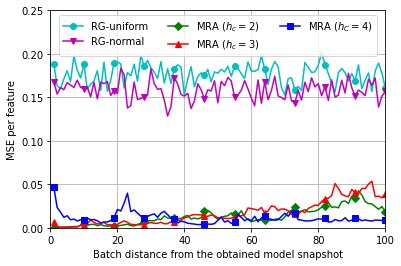

In [12]:
import numpy as np
import matplotlib.pyplot as plt

log_attack = np.loadtxt("./log/wine-white-2.csv", delimiter=",")
layer3 = np.loadtxt("./log/wine-white-3.csv", delimiter=",")[:,2]
layer4 = np.loadtxt("./log/wine-white-4.csv", delimiter=",")[:,2]

plt.xlim([0,100])
plt.ylim([0,0.25])
plt.grid()
plt.ylabel('MSE per feature')
plt.xlabel('Batch distance from the obtained model snapshot')
ran = [i+1 for i in range(100)]
plt.plot(
    ran, log_attack[:,0], 'co-',
    ran, log_attack[:,1], 'mv-',
    ran, log_attack[:,2], 'gD-',
    ran, layer3, 'r^-',
    ran, layer4, 'bs-',
    markevery=np.arange(0, 101, 9))
plt.legend(['RG-uniform', 'RG-normal', 'MRA ($h_c=2$)', 'MRA ($h_c=3$)', 'MRA ($h_C=4$)'], loc='upper center', ncol=3)
plt.savefig("fig/wine-white-234.pdf", bbox_inches='tight')